In [106]:
print ("Hello World")

import numpy as np

import sys
sys.version

from time import sleep
from time import time
from pynq import Overlay
from pynq import MMIO
from pynq import allocate

pl = Overlay("./axi_stream_lite_design_wrapper.bit")

ip_dict = pl.ip_dict
#print(ip_dict)

specific_ip_name = "axi_dma_0"  # ここで確認したいIPブロックの名前を指定
if specific_ip_name in ip_dict:
    #print(ip_dict[specific_ip_name])
    print(f"IPブロック {specific_ip_name} が存在します。")
else:
    print(f"エラー：IPブロック {specific_ip_name} は存在しません。")

specific_ip_name = "AXI_source_v1_0_0"  # ここで確認したいIPブロックの名前を指定
if specific_ip_name in ip_dict:
    #print(ip_dict[specific_ip_name])
    print(f"IPブロック {specific_ip_name} が存在します。")
else:
    print(f"エラー：IPブロック {specific_ip_name} は存在しません。")

Hello World
IPブロック axi_dma_0 が存在します。
IPブロック AXI_source_v1_0_0 が存在します。


In [107]:
#axi_Stream
dma = pl.axi_dma_0
dma_send = pl.axi_dma_0.sendchannel
dma_recv = pl.axi_dma_0.recvchannel

#axi_Lite
mmio = MMIO(base_addr = pl.ip_dict['AXI_source_v1_0_0']['phys_addr'],
            length = 0x1000,
            debug = True)
#axi = MMIO(2147483648)


mmio.write(0, 0); sleep(0.01);#PS is idle

read_count = 0

In [108]:
# 入出力バッファー
data_size =128
input_buffer = allocate(shape=(data_size,), dtype=np.uint64)
output_buffer = allocate(shape=(data_size+4,), dtype=np.uint64)

for i in range(data_size):
    #input_buffer[i] = i + 0xcafe0000
    input_buffer[i] = i + 1
    #input_buffer[i]=2**64-1 

In [115]:
# while_loop_calclation

mmio.write(0, 1);#PS is send(write) start
sleep(0.01)

start_time = time()  # 開始時間を記録

# sendコマンド
dma_send.transfer(input_buffer)
dma_send.wait()

# 計算完了まで待機
while mmio.read(8) <= read_count:
    sleep(0.002)
    
mmio.write(0, 2);#PS is recv(read) start

# recvコマンド
dma_recv.transfer(output_buffer)
dma_recv.wait()

end_time = time()  # 終了時間を記録
elapsed_time = end_time - start_time  # 経過時間を計算
print(f"計算にかかった時間: {elapsed_time} 秒")

autoencoding_count = mmio.read(8); #read enable(0 is still, n>=1 is autoencoding count)
calc_time = mmio.read(12); #calclation time counter
print(f"autoencoding_count : {autoencoding_count}")
print(f"calc_clock : {calc_time} clock")
PL_frequency = 100000000
print(f"calc_time : {calc_time/PL_frequency} second")

for i in range(data_size+4):
    #print('0x' + format(output_buffer[i], '02x'))
    #print(output_buffer[i])
    print(output_buffer[i], end=" ")

計算にかかった時間: 0.002089977264404297 秒
autoencoding_count : 4
calc_clock : 1195648 clock
calc_time : 0.01195648 second
128 128 128 128 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 

In [116]:
# axi streamの不要な先頭４データを削除
one_dim = np.array(output_buffer[4:], dtype=np.uint64)
print(one_dim)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128]


<IPython.core.display.Javascript object>


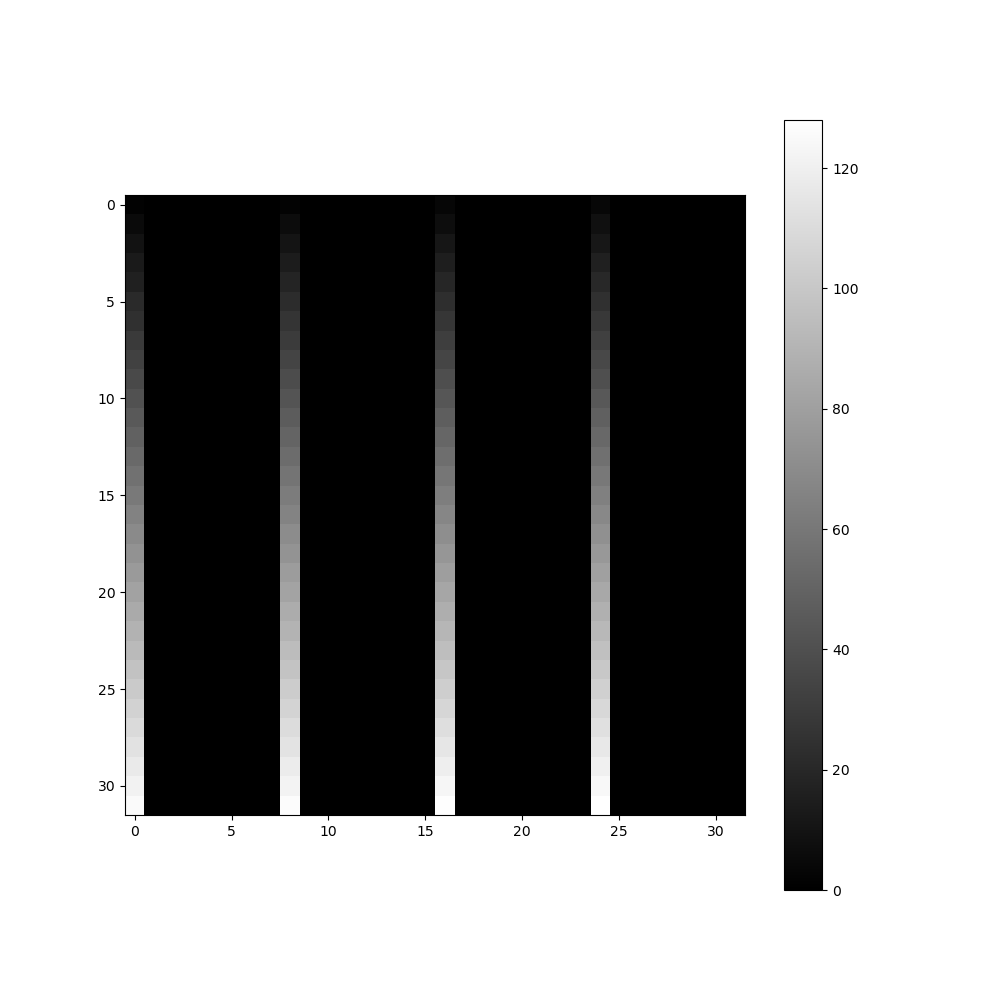

[[  1.   0.   0. ...   0.   0.   0.]
 [  5.   0.   0. ...   0.   0.   0.]
 [  9.   0.   0. ...   0.   0.   0.]
 ...
 [117.   0.   0. ...   0.   0.   0.]
 [121.   0.   0. ...   0.   0.   0.]
 [125.   0.   0. ...   0.   0.   0.]]


In [78]:
# output 32×32 2Dimage
import numpy as np
import matplotlib.pyplot as plt

def conv_32_32_array(one_dim):
    two_dim = np.zeros((32, 32))

    for i in range(128):
        value = int(one_dim[i])  # NumPyのuint64からPythonのintに変換
        byte1 = value & 0xFF
        byte2 = (value >> 8) & 0xFF
        byte3 = (value >> 16) & 0xFF
        byte4 = (value >> 24) & 0xFF
        byte5 = (value >> 32) & 0xFF
        byte6 = (value >> 40) & 0xFF
        byte7 = (value >> 48) & 0xFF
        byte8 = (value >> 56) & 0xFF
        y = int(i / 4)
        x = 8 * (i % 4)
        two_dim[y][x:x+8] = [byte1, byte2, byte3, byte4, byte5, byte6, byte7, byte8]

    # 二次元配列を画像として表示
    plt.figure(figsize=(10, 10))
    plt.imshow(two_dim, cmap='gray')  # カラーマップをグレースケールに設定
    plt.colorbar()  # カラーバーを表示
    plt.show()
    
    return two_dim

output = conv_32_32_array(one_dim)
print(output)

<IPython.core.display.Javascript object>


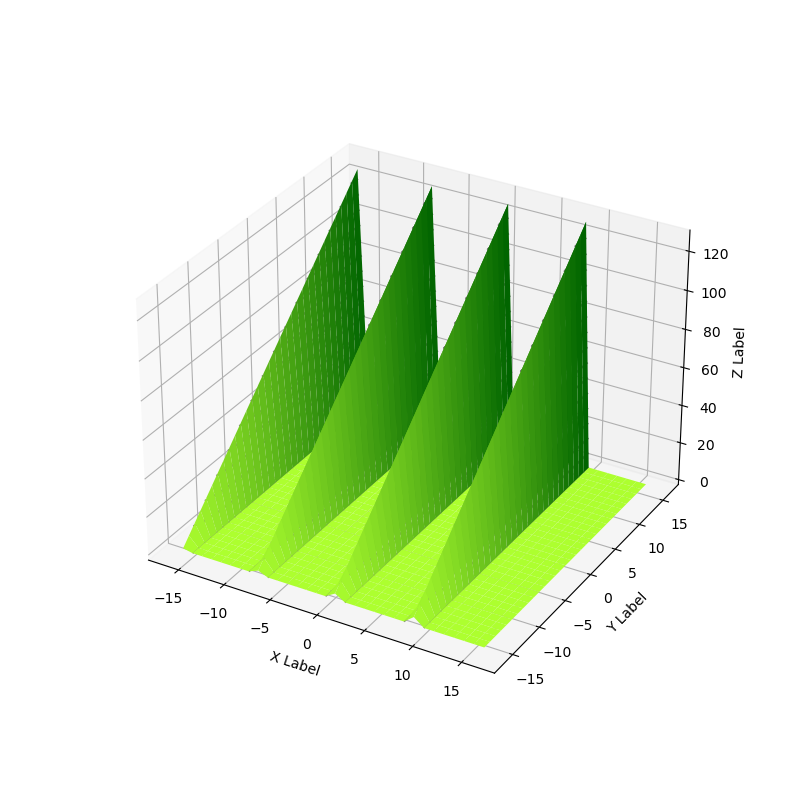

In [79]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

# 既存の二次元配列Zを定義
n_points = 32
#Z = np.random.rand(n_points, n_points) * 255  # ランダムな値でZを定義
Z=output

# X, Y座標のメッシュグリッドを作成
x = np.linspace(-16, 16, n_points)
y = np.linspace(-16, 16, n_points)
x, y = np.meshgrid(x, y)

# カスタムカラーマップを作成（黄緑色から濃い緑色へのグラデーション）
colors = ["greenyellow", "darkgreen"]  # 黄緑色から濃い緑色へ
cmap = LinearSegmentedColormap.from_list("my_cmap", colors)

# 3Dプロットの作成
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# カスタムカラーマップを使用して面を追加
ax.plot_surface(x, y, Z, rstride=1, cstride=1, cmap=cmap, edgecolor='none')

# 表面に等高線を灰色で追加
contour_levels = 15  # 等高線の数
ax.contour(x, y, Z, contour_levels, colors='gray')

# ラベルの追加
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# 3Dプロットの表示
plt.show()